# Player Heatmap

Tracks player location to give insight into how much time they are spending in certain areas of the map. One use case: shows where players usually get stuck.

In [ ]:
# From firestore service account creation tutorial

# import firebase_admin
# from firebase_admin import credentials

# cred = credentials.Certificate("../darklight-escape-firebase-adminsdk-fbsvc-1a69ac5240.json")
# firebase_admin.initialize_app(cred)

In [ ]:
# # db = firestore.client()

# # Stream X and Y coords from collection
# heatmap_data = db.collection("playerheatmap").stream()
# x_coords = []
# y_coords = []
# for doc in heatmap_data:
#     x_coords.append(doc.to_dict()["x"])
#     y_coords.append(doc.to_dict()["y"])

# # Plot heatmap data
# plt.figure(figsize=(10, 6))
# plt.scatter(x_coords, y_coords, alpha=0.5)
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.title("Player Heatmap")
# plt.grid(True)
# plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

In [ ]:
skip_stages = ["Tutorial1", "Level 1-1"]

def load_data(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    positions_data = []
    if "positions" in data:
        for key, pos in data["positions"].items():
            if pos.get("level") in skip_stages:
                continue
            positions_data.append(pos)

    collectibles_data = []
    if "collectibles" in data:
        for key, col in data["collectibles"].items():
            if col.get("level") == skip_stages:
                continue
            collectibles_data.append(col)

    # Convert to DataFrames
    positions_df = pd.DataFrame(positions_data)
    collectibles_df = pd.DataFrame(collectibles_data) if collectibles_data else pd.DataFrame(columns=["item", "level", "gameTime", "sessionId"])

    return positions_df, collectibles_df

In [ ]:
json_file_path = "darklight-escape-default-rtdb-export.json"
positions_df, collectibles_df = load_data(json_file_path)

print(f"Number of position records: {len(positions_df)}")
print(f"Number of collectible records: {len(collectibles_df)}")
print(f"Unique position sessions: {positions_df['sessionId'].nunique()}")
print(f"Unique collectible sessions: {collectibles_df['sessionId'].nunique()}")

Number of position records: 12337
Number of collectible records: 934
Unique position sessions: 470
Unique collectible sessions: 125


In [ ]:
# Death/Restart Locations
def plot_final_locations():
    last_positions = positions_df.sort_values('gameTime').groupby(['sessionId', 'level']).last().reset_index()
    levels = positions_df['level'].unique()

    fig, axes = plt.subplots(1, len(levels), figsize=(6*len(levels), 5))
    if len(levels) == 1:
        axes = [axes]

    for i, level in enumerate(levels):
        level_data = last_positions[last_positions['level'] == level]
        print(level, "has", level_data.shape[0], "datapoints")

        # Create scatter plot
        axes[i].scatter(level_data['x'], level_data['y'], alpha=0.7, s=50)
        axes[i].set_title(f'Final Player Positions in {level}')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        axes[i].grid(True)

        if len(level_data) > 5:  # Only if enough data
            try:
                sns.kdeplot(x=level_data['x'], y=level_data['y'], ax=axes[i], cmap="Reds", alpha=0.5)
            except:
                pass

    plt.tight_layout()
    plt.savefig('player_final_positions.png', dpi=300)
    plt.show()

In [ ]:
def plot_time_spent():
    session_times = positions_df.groupby(['sessionId', 'level']).agg({
        'gameTime': ['min', 'max']
    }).reset_index()
    session_times.columns = ['sessionId', 'level', 'start_time', 'end_time']
    session_times['duration'] = session_times['end_time'] - session_times['start_time']

    level_durations = session_times.groupby('level')['duration'].mean().reset_index()

    # Create bar chart
    # plt.figure(figsize=(10, 6))
    # bar = sns.barplot(x='level', y='duration', data=level_durations)
    # for i, v in enumerate(level_durations['duration']):
    #     bar.text(i, v + 0.1, f"{v:.1f}s", ha='center')

    # plt.title('Average Time Spent per Level')
    # plt.xlabel('Level')
    # plt.ylabel('Duration (seconds)')
    # plt.tight_layout()
    # plt.savefig('time_spent_per_level.png', dpi=300)
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='level', y='duration', data=session_times)
    plt.title('Distribution of Time Spent per Level')
    plt.xlabel('Level')
    plt.ylabel('Duration (seconds)')
    plt.tight_layout()
    plt.savefig('time_spent_distribution.png', dpi=300)
    plt.show()

In [ ]:
def plot_stars_collected():
    if 'item' not in collectibles_df.columns or len(collectibles_df) == 0:
        print("No collectibles data available")
        return

    # Filter stars only
    stars_df = collectibles_df[collectibles_df['item'] == 'Star']

    if len(stars_df) == 0:
        print("No stars collected data available")
        return

    # Count stars per level and session
    stars_per_session = stars_df.groupby(['sessionId', 'level']).size().reset_index(name='stars')

    # Calculate average stars collected per level
    stars_per_level = stars_per_session.groupby('level')['stars'].mean().reset_index()

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bar = sns.barplot(x='level', y='stars', data=stars_per_level)

    # Add text labels on bars
    for i, v in enumerate(stars_per_level['stars']):
        bar.text(i, v + 0.1, f"{v:.1f}", ha='center')

    plt.title('Average Stars Collected per Level')
    plt.xlabel('Level')
    plt.ylabel('Number of Stars')
    plt.tight_layout()
    plt.savefig('stars_collected.png', dpi=300)
    plt.show()

    # Create count plot to see distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x='level', hue='stars', data=stars_per_session)
    plt.title('Distribution of Stars Collected per Level')
    plt.xlabel('Level')
    plt.ylabel('Count of Sessions')
    plt.legend(title="Stars")
    plt.tight_layout()
    plt.savefig('stars_distribution.png', dpi=300)
    plt.show()

In [ ]:
def generate_position_heatmap():
    # Get unique levels
    levels = positions_df['level'].unique()

    # Create subplot for each level
    fig, axes = plt.subplots(1, len(levels), figsize=(7*len(levels), 6))
    if len(levels) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one level

    for i, level in enumerate(levels):
        level_data = positions_df[positions_df['level'] == level]

        # Create heatmap using hexbin
        hb = axes[i].hexbin(level_data['x'], level_data['y'],
                           gridsize=30, cmap='inferno',
                           bins='log', alpha=0.8)

        axes[i].set_title(f'Player Position Heatmap - {level}')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')

        # Add colorbar
        cb = plt.colorbar(hb, ax=axes[i])
        cb.set_label('Log Player Count')

    plt.tight_layout()
    plt.savefig('player_position_heatmap.png', dpi=300)
    plt.show()

Level 1 has 128 datapoints
Level 2 has 76 datapoints
Level 3 has 34 datapoints
Level 2-Beta has 104 datapoints
Level 1-Beta has 68 datapoints
Level 3-Beta has 60 datapoints


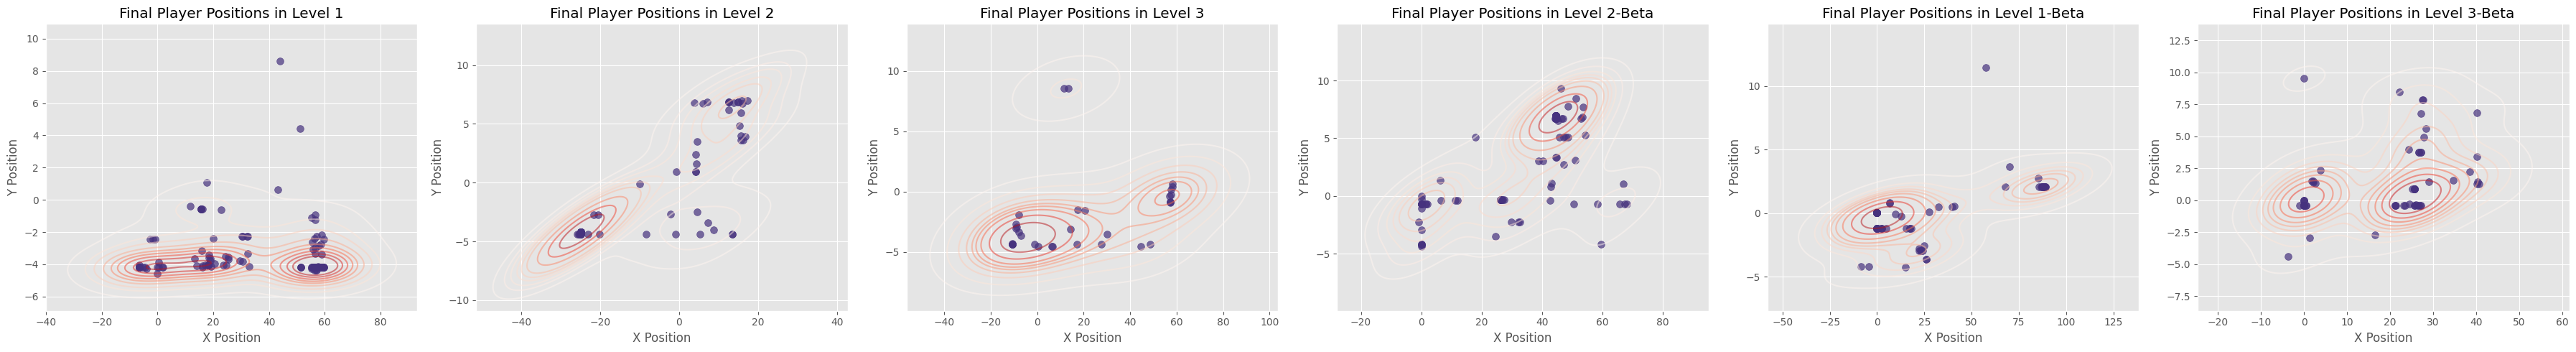

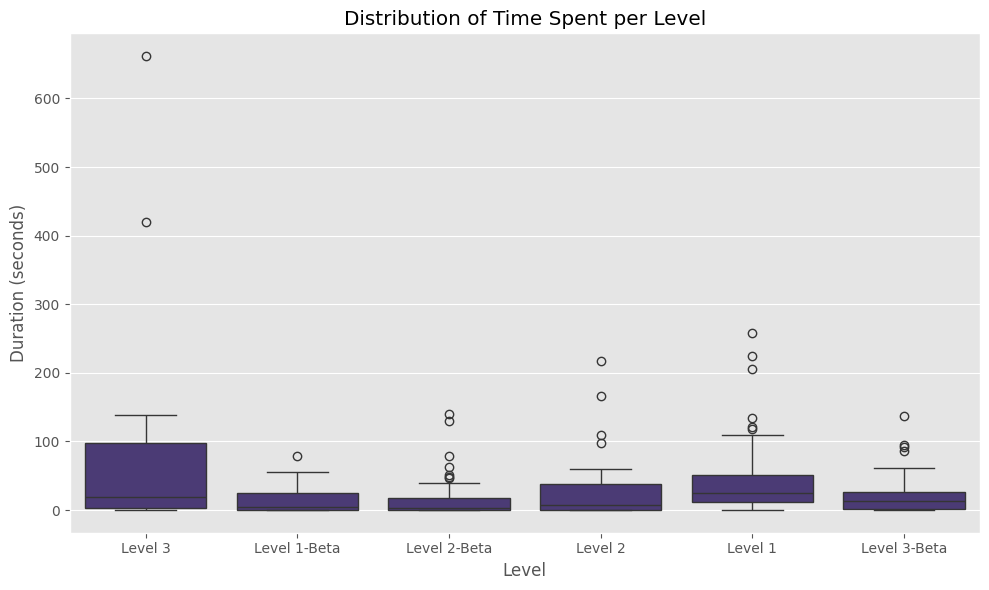

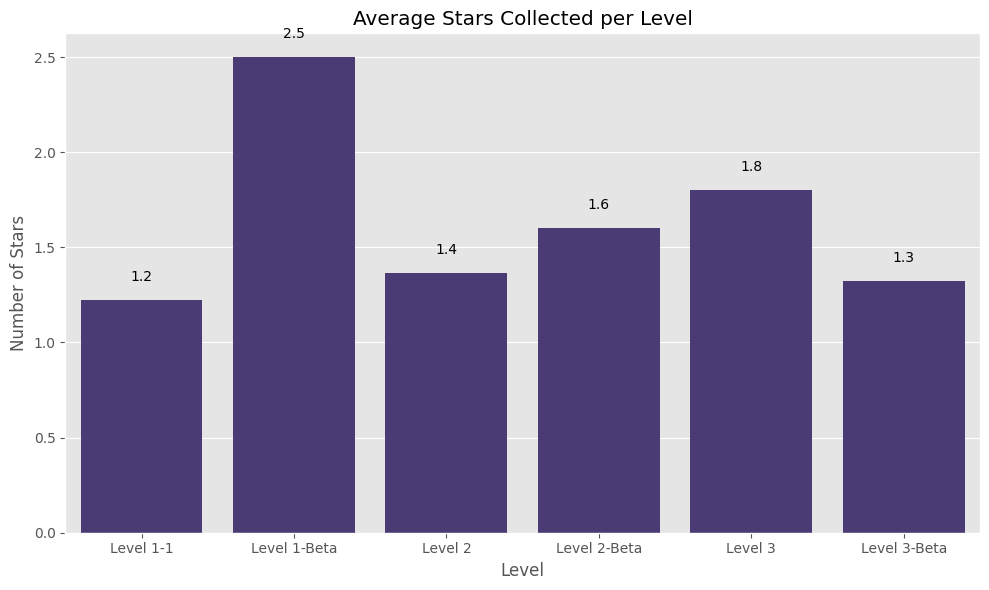

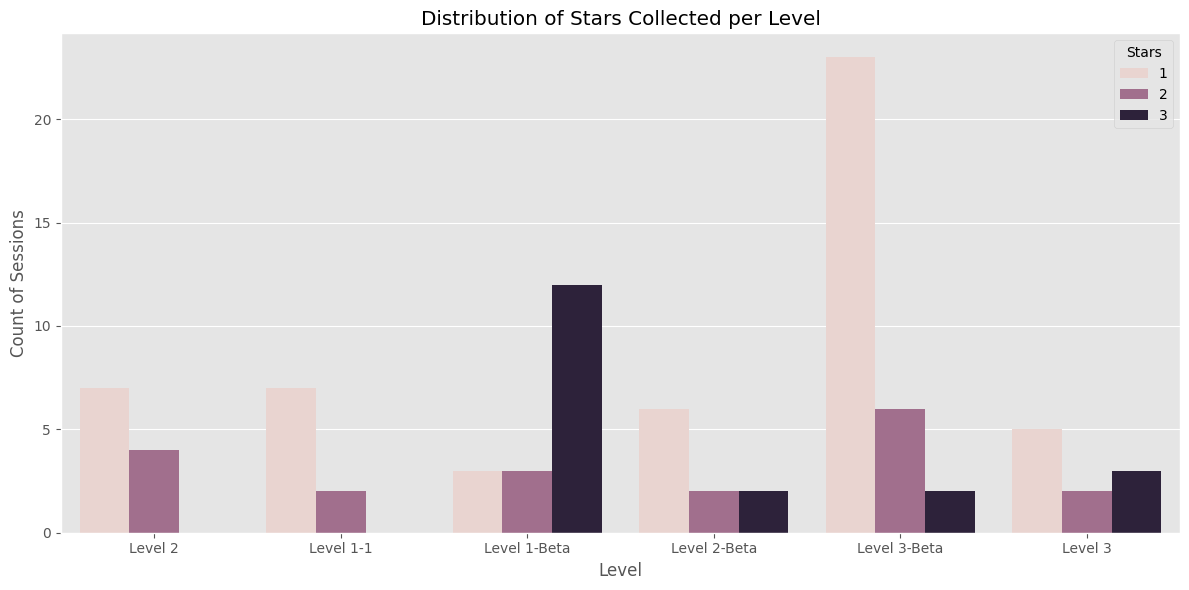

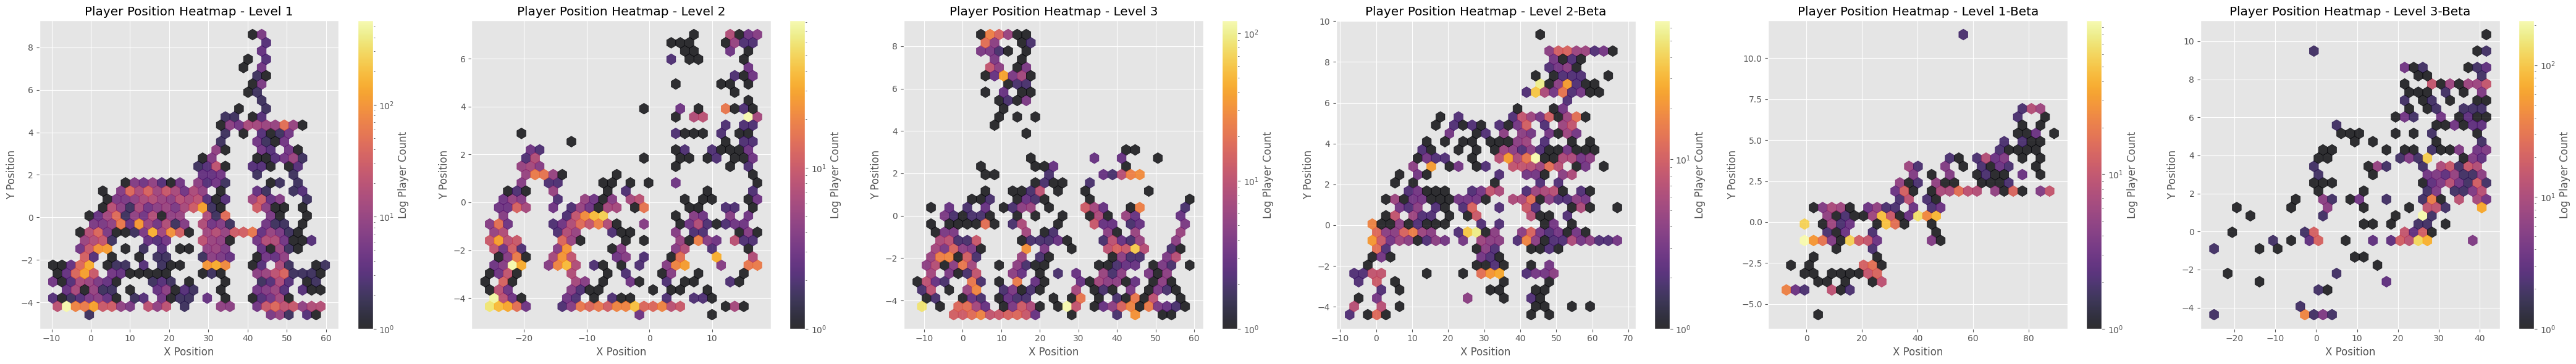

In [ ]:
plt.style.use('ggplot')
sns.set_palette("viridis")

plot_final_locations()
plot_time_spent()
plot_stars_collected()
generate_position_heatmap()

In [ ]:
def get_random_session_data(df):
    """
    Takes a random row from the DataFrame, extracts its sessionId,
    and returns all rows in the DataFrame with that sessionId.

    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'sessionId' column

    Returns:
    pandas.DataFrame: All rows with the randomly selected sessionId
    tuple: (sessionId, DataFrame rows)
    """
    # Check if the DataFrame has a sessionId column
    if 'sessionId' not in df.columns:
        raise ValueError("DataFrame must contain a 'sessionId' column")

    # Check if DataFrame is empty
    if df.empty:
        raise ValueError("DataFrame is empty")

    # Take 1 random row from the DataFrame
    random_row = df.sample(n=1)

    # Extract the sessionId from the random row
    random_session_id = random_row['sessionId'].iloc[0]

    # Get all rows with this sessionId
    session_data = df[df['sessionId'] == random_session_id]
    session_data = session_data.sort_values('gameTime')

    print(f"Selected random sessionId: {random_session_id}")
    print(f"Found {len(session_data)} rows with this sessionId")

    return random_session_id, session_data

Selected random sessionId: 594b9cb8-1d2d-454a-aded-64dfa84de0a6
Found 5 rows with this sessionId


KeyError: 0

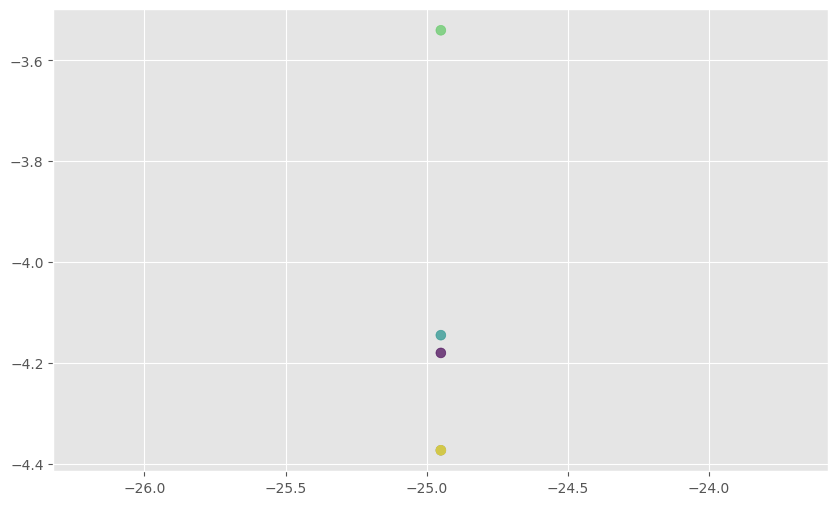

In [ ]:
random_session_id, session_data = get_random_session_data(positions_df)

plt.figure(figsize=(10, 6))
plt.scatter(session_data['x'],
            session_data['y'],
            c=session_data['gameTime'],
            cmap='viridis',
            s=50,
            alpha=0.7)
# plt.plot(session_data['x'], session_data['y'], 'r--', alpha=0.5)
plt.title(f'Session {random_session_id}, {session_data[0]["level"]}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()

# random_session_id, session_data = get_random_session_data(collectibles_df)
